In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
filename = "data/xyzt_wild.csv"

df = pd.read_csv(filename, names=["x", "y", "z", "t"])
df["x_round"] = df["x"].apply(lambda x: round(x, 2))
df["y_round"] = df["y"].apply(lambda x: round(x, 2))
df["z_round"] = df["z"].apply(lambda x: round(x, 2))
df

,x,y,z,t,x_round,y_round,z_round
0,0.849096,-7.728835,-0.364316,0,0.85,-7.73,-0.36
1,0.852161,-7.733792,-0.363104,1,0.85,-7.73,-0.36
2,2.607776,-0.110870,1.149897,0,2.61,-0.11,1.15
3,2.607422,-0.118292,1.143971,1,2.61,-0.12,1.14
4,0.996751,1.156340,1.080643,0,1.00,1.16,1.08
...,...,...,...,...,...,...,...
9087,4.991942,5.526703,4.272528,9931,4.99,5.53,4.27
9088,4.994120,5.520236,4.266598,9932,4.99,5.52,4.27
9089,-2.898865,7.732357,6.428355,9933,-2.90,7.73,6.43
9090,-2.895280,7.721706,6.420709,9934,-2.90,7.72,6.42


In [3]:
df.describe() 

,x,y,z,t,x_round,y_round,z_round
count,9092.000000,9092.000000,9092.000000,9092.000000,9092.000000,9092.000000,9092.000000
mean,-0.463489,0.927992,1.373422,5065.284756,-0.463479,0.927950,1.373416
std,2.996265,2.819167,1.460823,3083.546867,2.996240,2.819203,1.460790
min,-17.764479,-11.012404,-8.531316,0.000000,-17.760000,-11.010000,-8.530000
25%,-2.101284,-0.577083,0.290054,2177.000000,-2.100000,-0.580000,0.290000
50%,-0.206203,0.796754,0.898806,5223.500000,-0.210000,0.800000,0.900000
75%,1.228215,2.843853,2.215275,7763.000000,1.230000,2.840000,2.220000
max,12.827523,19.592147,15.447616,9950.000000,12.830000,19.590000,15.450000


In [4]:
print("unique x:", len(df["x"].unique()))
print("unique x rounded:", len(df["x_round"].unique()))
print("unique y:", len(df["y"].unique()))
print("unique y rounded:", len(df["y_round"].unique()))
print("unique z:", len(df["z"].unique()))
print("unique z rounded:", len(df["z_round"].unique()))

unique x: 9044
unique x rounded: 1453
unique y: 9044
unique y rounded: 1369
unique z: 9044
unique z rounded: 712


In [5]:
# adjusts a value's range to start at 0 so it can be cleanly divided for voxel number
def adjust_start_0(val, overall_min):
    if overall_min < 0:
        return val + (-overall_min)
    else:
        return val - overall_min

def xyz_to_voxel_xyz(x, y, z, voxel_length, min_x, min_y, min_z):
    x_adj = adjust_start_0(x, min_x)
    y_adj = adjust_start_0(y, min_y)
    z_adj = adjust_start_0(z, min_z)
    
    return (
        x_adj // voxel_length,
        y_adj // voxel_length,
        z_adj // voxel_length
    )

In [6]:
voxels_to_activation_times = {}

min_x = df["x"].min()
min_y = df["y"].min()
min_z = df["z"].min()

voxel_length = 0.5

for index, row in df.iterrows():
    x = row["x"]
    y = row["y"]
    z = row["z"]
    t = row["t"]
    
    voxel = xyz_to_voxel_xyz(x, y, z, voxel_length, min_x, min_y, min_z)
    if voxel in voxels_to_activation_times:
        voxels_to_activation_times[voxel].append(t)
    else:
        voxels_to_activation_times[voxel] = [t]

print("unique voxels for length %s: %s" % (voxel_length, len(voxels_to_activation_times)))

unique voxels for length 0.5: 1117


In [7]:
def voxel_to_position(vx, vy, vz, voxel_length, min_x, min_y, min_z):
    x = (vx*voxel_length) + min_x
    y = (vy*voxel_length) + min_y
    z = (vz*voxel_length) + min_z
    
    return (x, y, z)

active_voxel_coords = list(
    map(
    lambda x: voxel_to_position(x[0],
                                x[1],
                                x[2],
                                voxel_length,
                               min_x,
                               min_y,
                               min_z
                               ),
    voxels_to_activation_times.keys()))

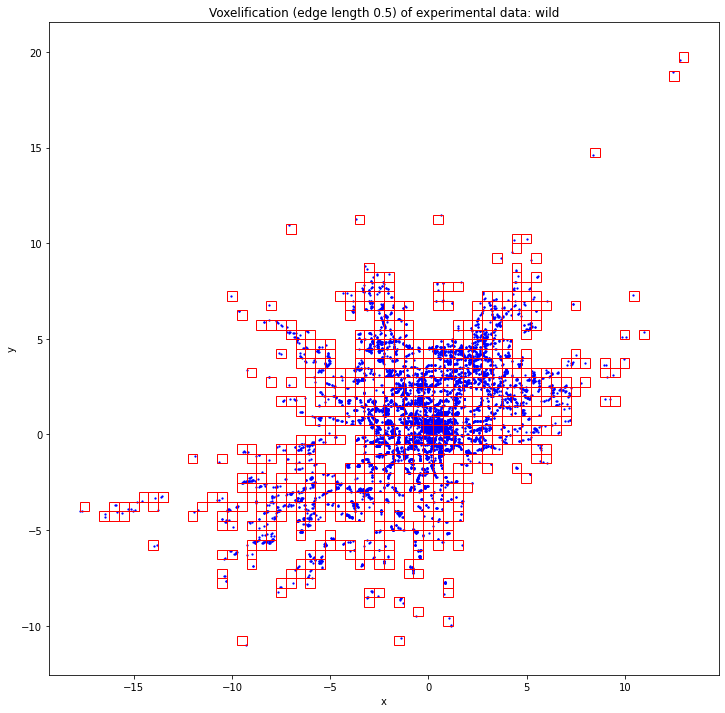

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(df["x"], df["y"], s=1.5, alpha=1, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Voxelification (edge length 0.5) of experimental data: wild")

for x, y, z in active_voxel_coords:
    # https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image
    rect = patches.Rectangle((x, y),
                             voxel_length,
                             voxel_length,
                             facecolor=None,
                             edgecolor="r",
                             linewidth=1,
                             fill=False)
    ax.add_patch(rect)
    
fig.savefig("figures/voxelification_xy.png", dpi=300)

In [9]:
def csv_to_voxels_with_t(filename, voxel_length):
    # first, make df and calc some stats
    df = pd.read_csv(filename, names=["x", "y", "z", "t"])
    df["x_round"] = df["x"].apply(lambda x: round(x, 2))
    df["y_round"] = df["y"].apply(lambda x: round(x, 2))
    df["z_round"] = df["z"].apply(lambda x: round(x, 2))
    
    print("rows:", len(df))
    print("unique x:", len(df["x"].unique()))
    print("unique x rounded:", len(df["x_round"].unique()))
    print("unique y:", len(df["y"].unique()))
    print("unique y rounded:", len(df["y_round"].unique()))
    print("unique z:", len(df["z"].unique()))
    print("unique z rounded:", len(df["z_round"].unique()))
    
    min_x = df["x"].min()
    min_y = df["y"].min()
    min_z = df["z"].min()
    
    # build voxels
    voxels_to_activation_times = {}
    
    for index, row in df.iterrows():
        x = row["x"]
        y = row["y"]
        z = row["z"]
        t = row["t"]
        
        voxel = xyz_to_voxel_xyz(x, y, z, voxel_length, min_x, min_y, min_z)
        if voxel in voxels_to_activation_times:
            voxels_to_activation_times[voxel].append(t)
        else:
            voxels_to_activation_times[voxel] = [t]
    
    print("populated voxels for length %s: %s" % (voxel_length, len(voxels_to_activation_times)))
    
    # move voxels back to real positions (so they aren't integers that min at 0,
    # which was a convenience for creating them)
    
    real_voxels_to_activation_times = {
        voxel_to_position(key[0], key[1], key[2],
                          voxel_length,
                          min_x, min_y, min_z): ts
        for key, ts in voxels_to_activation_times.items()
    }
    
    return real_voxels_to_activation_times, df

In [10]:
voxeled_wild_05, df_wild_05 = csv_to_voxels_with_t("data/xyzt_wild.csv", 0.5)

rows: 9092
unique x: 9044
unique x rounded: 1453
unique y: 9044
unique y rounded: 1369
unique z: 9044
unique z rounded: 712
populated voxels for length 0.5: 1117


In [11]:
voxeled_wild_05

{(0.7355210708873017, -8.0124044960004, -0.5313162146131205): [0.0,
  1.0,
  16.0,
  17.0,
  32.0,
  33.0,
  34.0,
  49.0,
  50.0],
 (2.2355210708873017, -0.5124044960004, 0.9686837853868795): [0.0,
  1.0,
  14.0,
  16.0,
  17.0],
 (0.7355210708873017, 0.9875955039996, 0.9686837853868795): [0.0,
  1.0,
  2.0,
  13.0,
  356.0,
  357.0,
  358.0,
  359.0,
  5849.0,
  8085.0,
  8086.0,
  8088.0,
  8726.0],
 (3.2355210708873017, 6.9875955039996, 4.9686837853868795): [0.0, 14.0, 15.0],
 (-4.264478929112698, 1.9875955039996, 0.4686837853868795): [0.0, 1.0, 2.0],
 (-3.7644789291126983, 0.9875955039996, 0.9686837853868795): [0.0,
  1.0,
  2.0,
  16.0,
  17.0,
  18.0,
  19.0,
  33.0,
  34.0,
  35.0,
  318.0],
 (-2.2644789291126983, 0.48759550399960006, 0.4686837853868795): [4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  38.0,
  39.0,
  40.0,
  41.0,
  55.0,
  56.0,
  57.0,
  58.0,
  309.0,
  310.0,
  324.0,
  325.0,
  326.0,
  327.0,
  340.0,
  341.0,
  342.0,
  343.0

In [12]:
def visualize_voxels_and_points(voxeled, df, voxel_length):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    ax.scatter(df["x"], df["y"], s=1.5, alpha=1, color="blue")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    for x, y, z in voxeled:
        # https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image
        rect = patches.Rectangle((x, y),
                                 voxel_length,
                                 voxel_length,
                                 facecolor=None,
                                 edgecolor="r",
                                 linewidth=1,
                                 fill=False)
        ax.add_patch(rect)
    return fig, ax

Text(0.5, 1.0, 'Wild with Voxel Length 0.5')

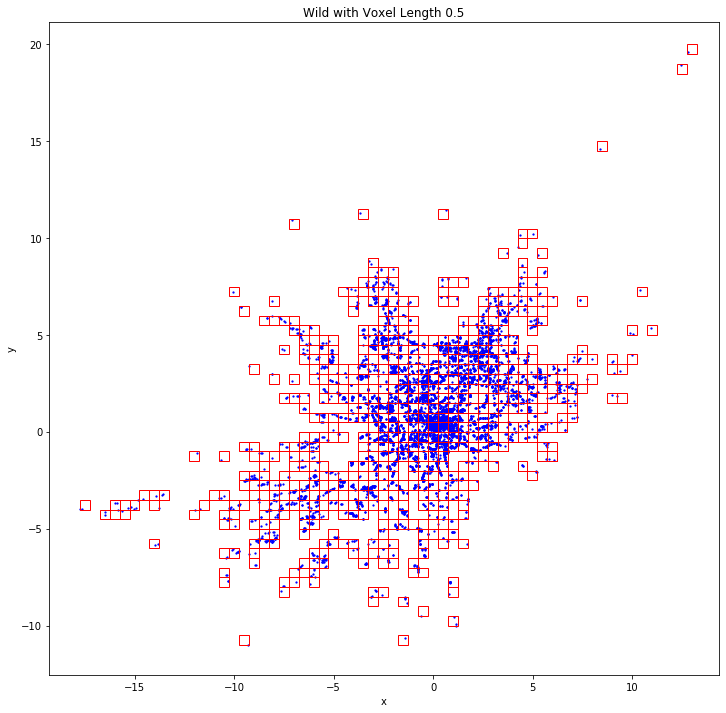

In [13]:
fig, ax = visualize_voxels_and_points(voxeled_wild_05, df_wild_05, 0.5)
ax.set_title("Wild with Voxel Length 0.5")

rows: 23058
unique x: 21725
unique x rounded: 187
unique y: 21725
unique y rounded: 152
unique z: 21725
unique z rounded: 131
populated voxels for length 0.04: 2677


Text(0.5, 1.0, 'Tent with Voxel Length 0.04')

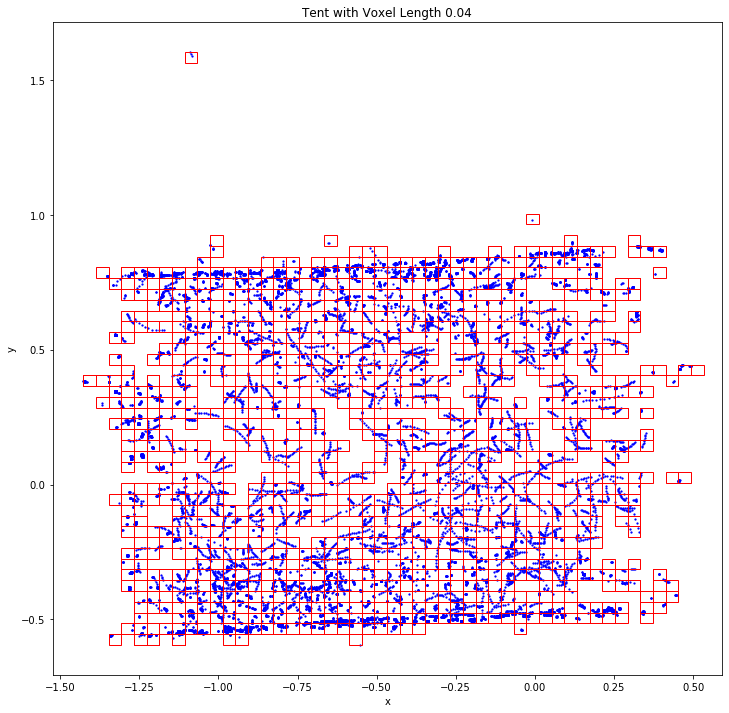

In [14]:
voxeled_tent_004, df_tent_004 = csv_to_voxels_with_t("data/xyzt_tent.csv", 0.04)

fig, ax = visualize_voxels_and_points(voxeled_tent_004, df_tent_004, 0.04)
ax.set_title("Tent with Voxel Length 0.04")

In [15]:
def organize_voxels_in_time(voxeled):
    voxels_present_at_time_t = {}
    for vxl in voxeled.keys():
        for t in voxeled[vxl]:
            if not voxels_present_at_time_t.get(t):
                voxels_present_at_time_t[t] = [vxl]
            else:
                voxels_present_at_time_t[t].append(vxl)
    return voxels_present_at_time_t

In [16]:
time_evolving_voxels = organize_voxels_in_time(voxeled_wild_05)
time_evolving_voxels

{0.0: [(0.7355210708873017, -8.0124044960004, -0.5313162146131205),
  (2.2355210708873017, -0.5124044960004, 0.9686837853868795),
  (0.7355210708873017, 0.9875955039996, 0.9686837853868795),
  (3.2355210708873017, 6.9875955039996, 4.9686837853868795),
  (-4.264478929112698, 1.9875955039996, 0.4686837853868795),
  (-3.7644789291126983, 0.9875955039996, 0.9686837853868795)],
 1.0: [(0.7355210708873017, -8.0124044960004, -0.5313162146131205),
  (2.2355210708873017, -0.5124044960004, 0.9686837853868795),
  (0.7355210708873017, 0.9875955039996, 0.9686837853868795),
  (-4.264478929112698, 1.9875955039996, 0.4686837853868795),
  (-3.7644789291126983, 0.9875955039996, 0.9686837853868795)],
 16.0: [(0.7355210708873017, -8.0124044960004, -0.5313162146131205),
  (2.2355210708873017, -0.5124044960004, 0.9686837853868795),
  (-3.7644789291126983, 0.9875955039996, 0.9686837853868795),
  (-1.2644789291126983, -3.0124044960004, -0.03131621461312051),
  (-3.7644789291126983, -2.0124044960004, -0.031316

<IPython.core.display.Javascript object>


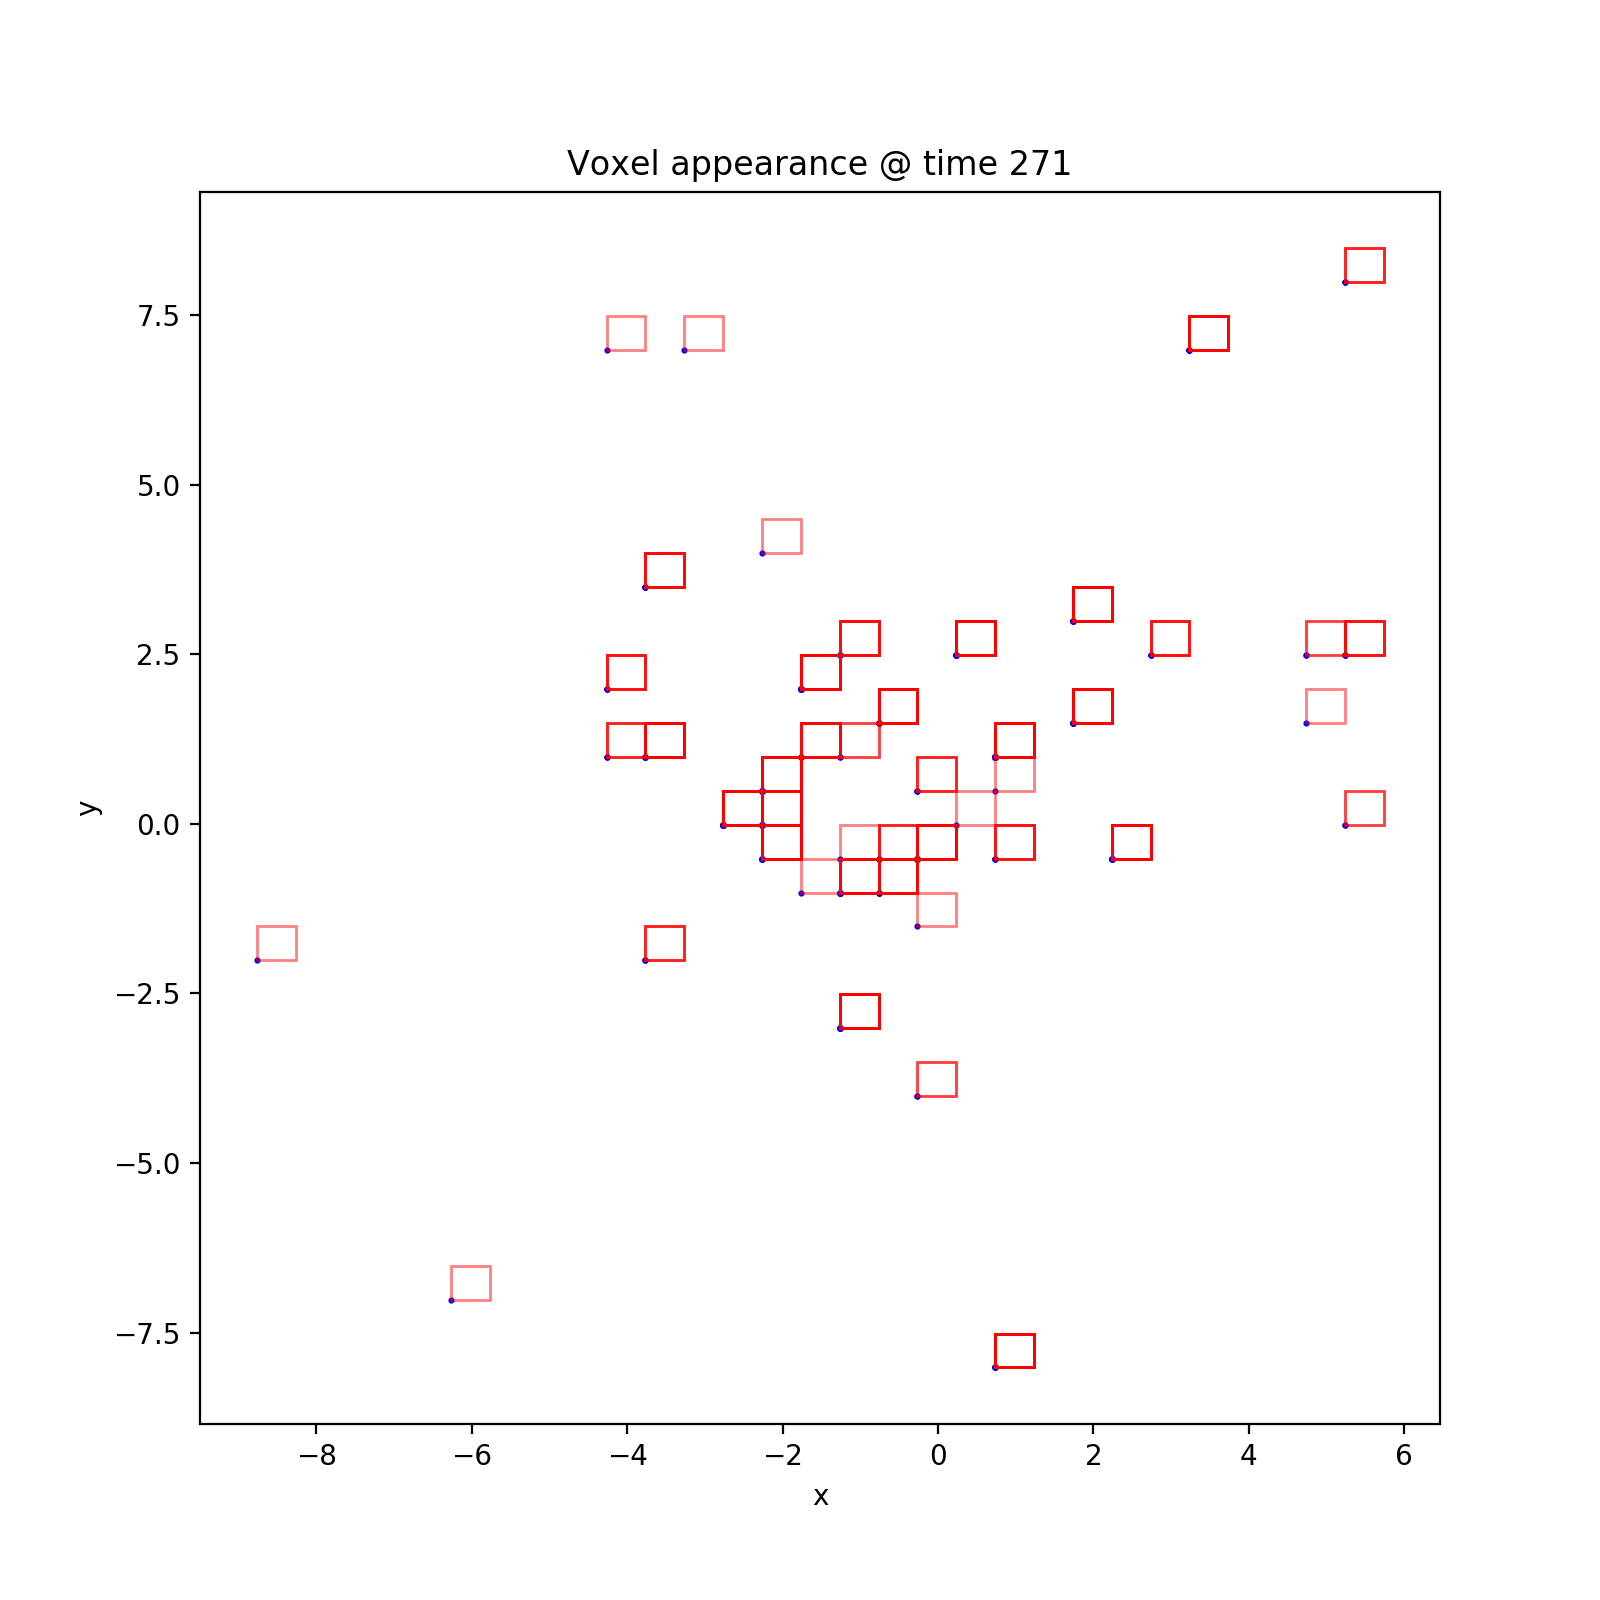

In [25]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
%matplotlib notebook


def animate_voxel_appearance(voxels_over_time, df):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    def animate(i):
        if voxels_over_time.get(float(i)):
            xs = [vxl[0] for vxl in voxels_over_time[float(i)]]
            ys = [vxl[1] for vxl in voxels_over_time[float(i)]]
            zs = [vxl[2] for vxl in voxels_over_time[float(i)]]
    #         df_xs = df["x"]["t" == i]
    #         df_ys = df["y"]["t" == i]
    #         df_zs = df["z"]["t" == i]
            ax.scatter(xs, ys, s=1.5, alpha=1, color="blue")

            ax.set_title("Voxel appearance @ time {}".format(i))
            for x, y in zip(xs, ys):
                rect = patches.Rectangle((x, y),
                                         voxel_length,
                                         voxel_length,
                                         facecolor="r",
                                         edgecolor="r",
                                         linewidth=1,
                                         fill=False,
                                         alpha=0.5)
                ax.add_patch(rect)
            

    
    num_keys = len(voxels_over_time.keys())
    anim = FuncAnimation(fig, animate, frames=num_keys, interval=100, blit=False, repeat=False)
    return anim

anim = animate_voxel_appearance(time_evolving_voxels, df_wild_05)


<IPython.core.display.Javascript object>


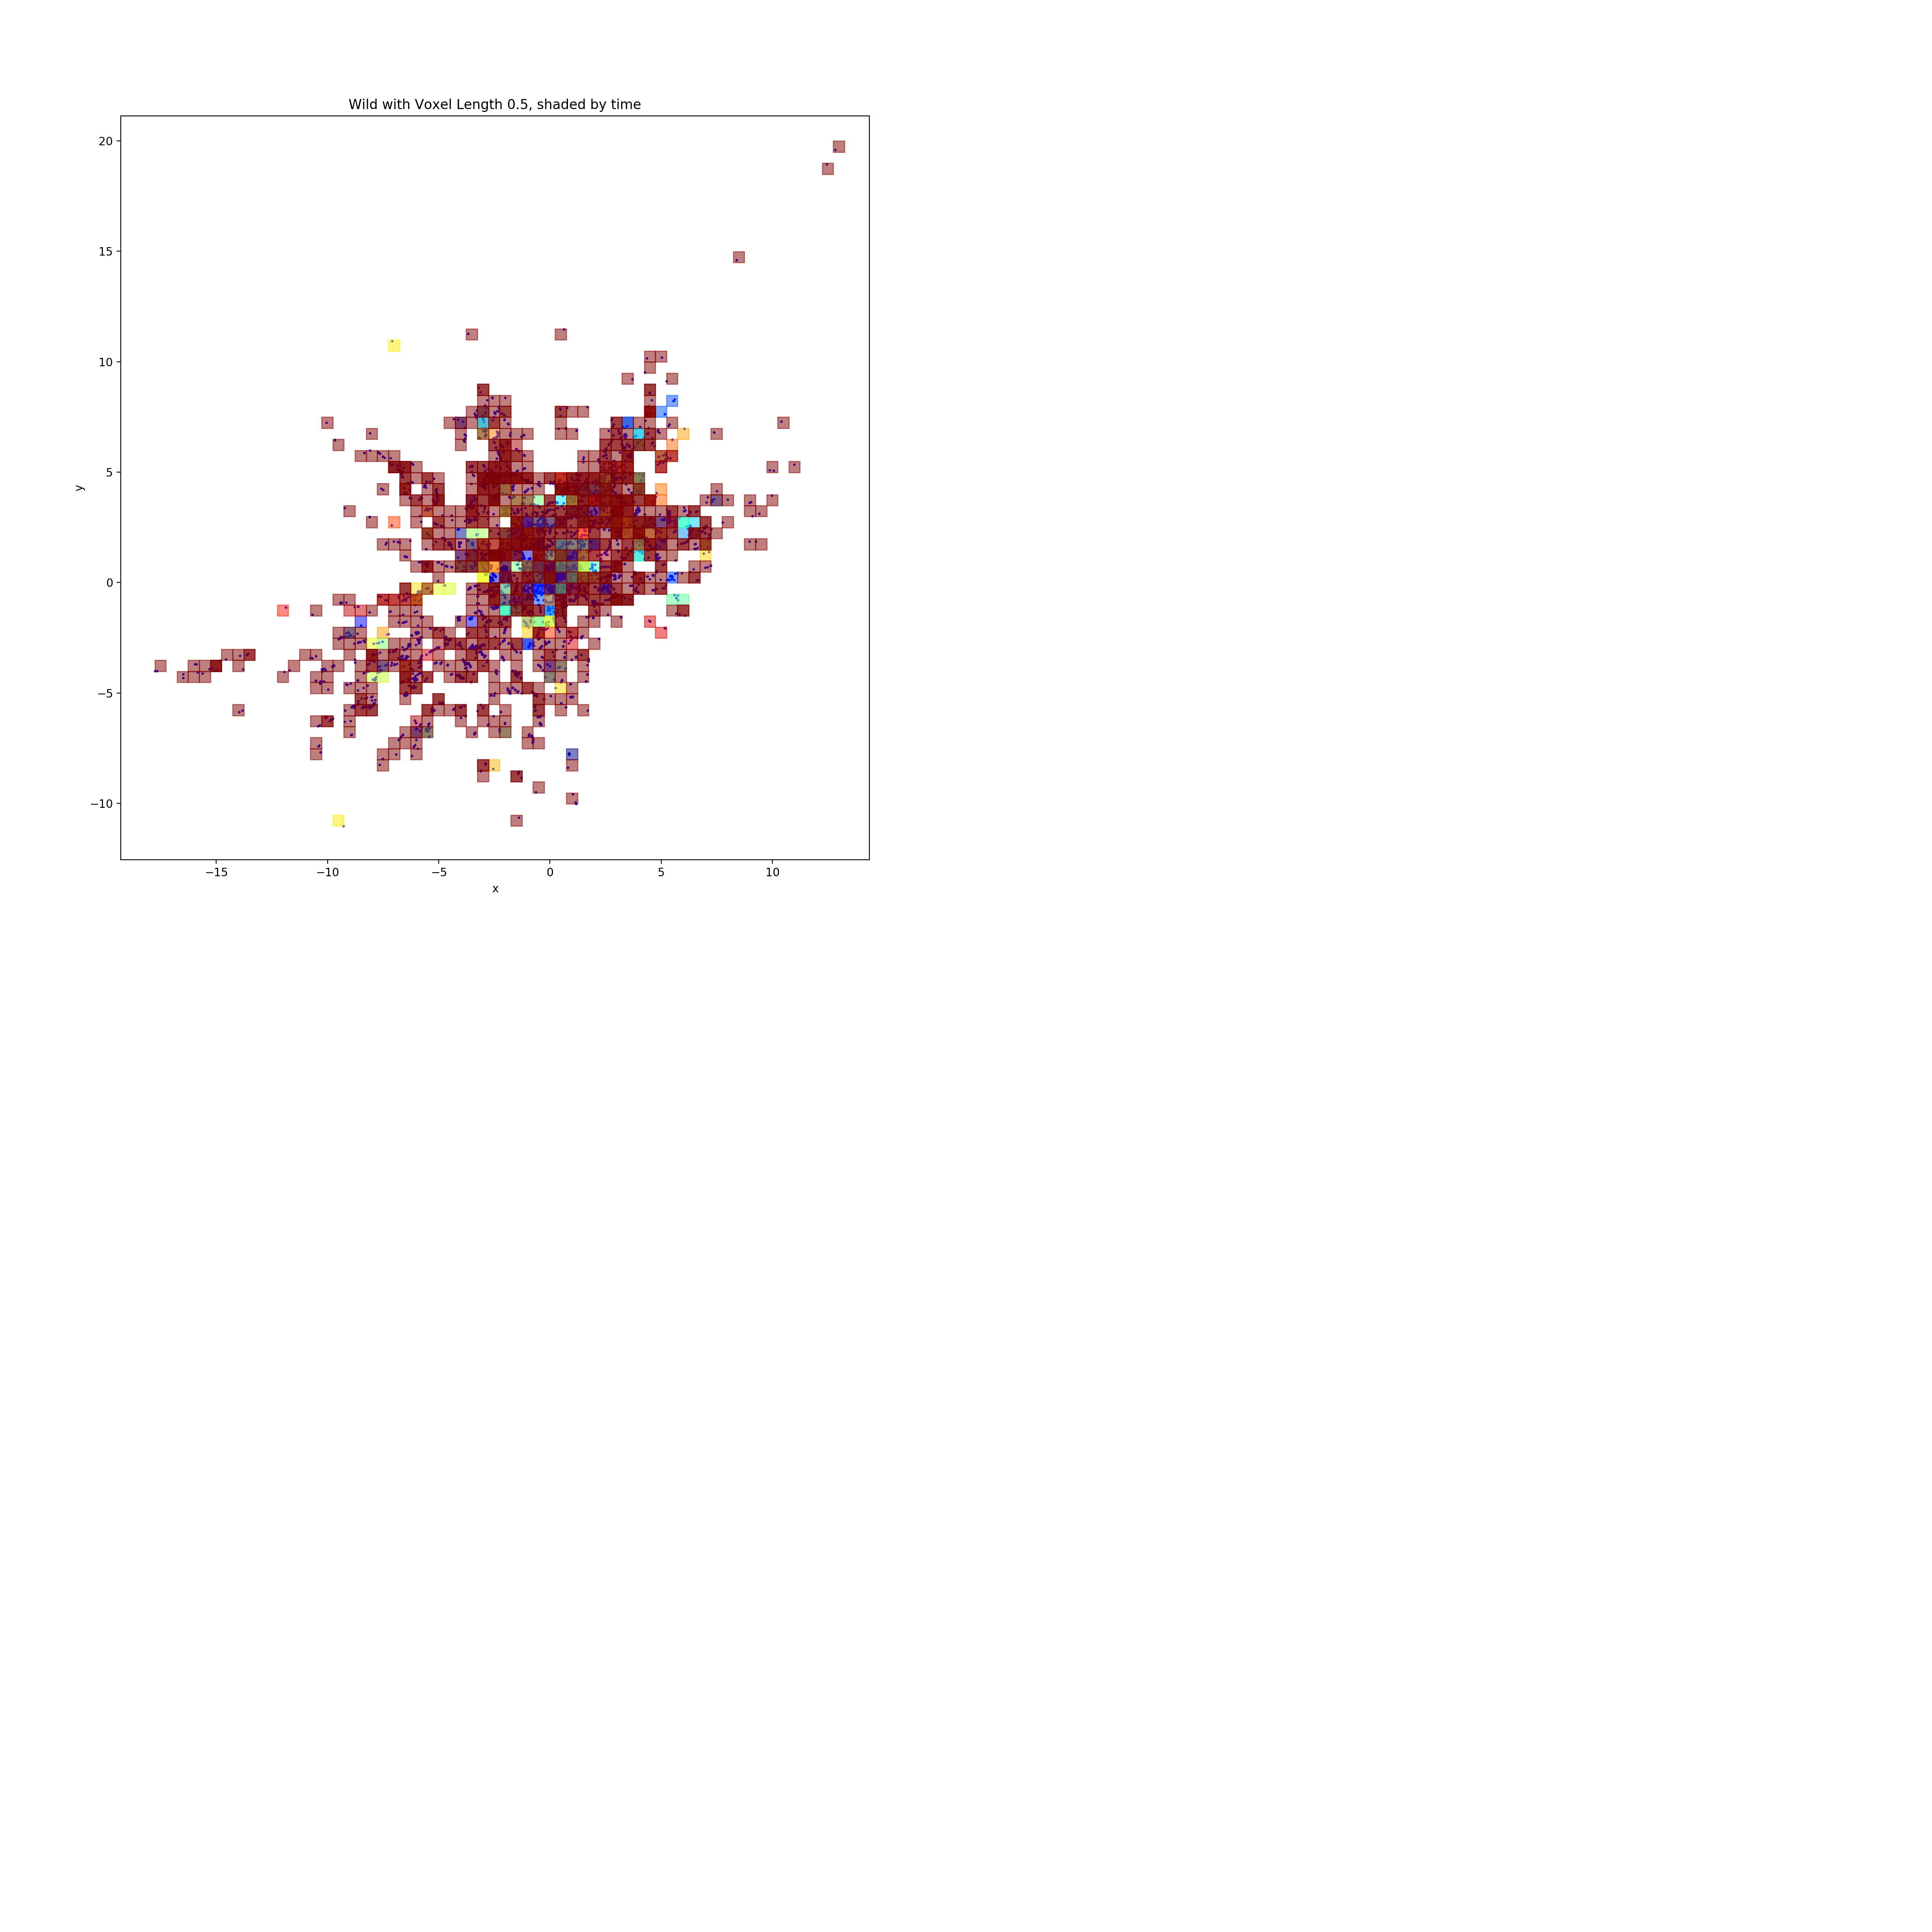

Text(0.5, 1.0, 'Wild with Voxel Length 0.5, shaded by time')

In [50]:
def visualize_voxels_and_points_in_time(voxeled, time_evolving_voxeled, df, voxel_length):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    ax.scatter(df["x"], df["y"], s=1.5, alpha=1, color="blue")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    def get_key(voxel_position, time_evolving_voxeled):
        for key, value in time_evolving_voxeled.items():
            if voxel_position in value:
                return key 
    
    ts = {}
    cmap = plt.cm.get_cmap(plt.get_cmap("jet"))

    for x, y, z in voxeled:
        ts[(x,y,z)] = get_key((x,y,z), time_evolving_voxeled)
    normed_ts = [float(t) / max(list(ts.values())) for t in list(ts.values())]
    cascade_voxels = {}
    
    for i, (x, y, z) in enumerate(voxeled):
        if cascade_voxels.get((x,y,z)):
            # https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image
            rect = patches.Rectangle((x, y),
                                     voxel_length,
                                     voxel_length,
                                     facecolor=cmap(i),
                                     edgecolor=cmap(i),
                                     linewidth=1,
                                     fill=True,
                                     alpha=0.5)
            ax.add_patch(rect)
            

        else:
            rect = patches.Rectangle((x, y),
                                     voxel_length,
                                     voxel_length,
                                     facecolor=cmap(i),
                                     edgecolor=cmap(i),
                                     linewidth=1,
                                     fill=True,
                                     alpha=0.5)
            ax.add_patch(rect)
            cascade_voxels[(x,y,z)] = 1
    return fig, ax

time_evolving_voxeled_wild_05 = organize_voxels_in_time(voxeled_wild_05)
fig, ax = visualize_voxels_and_points_in_time(voxeled_wild_05, time_evolving_voxeled_wild_05, df_wild_05, 0.5)
ax.set_title("Wild with Voxel Length 0.5, shaded by time")

<IPython.core.display.Javascript object>


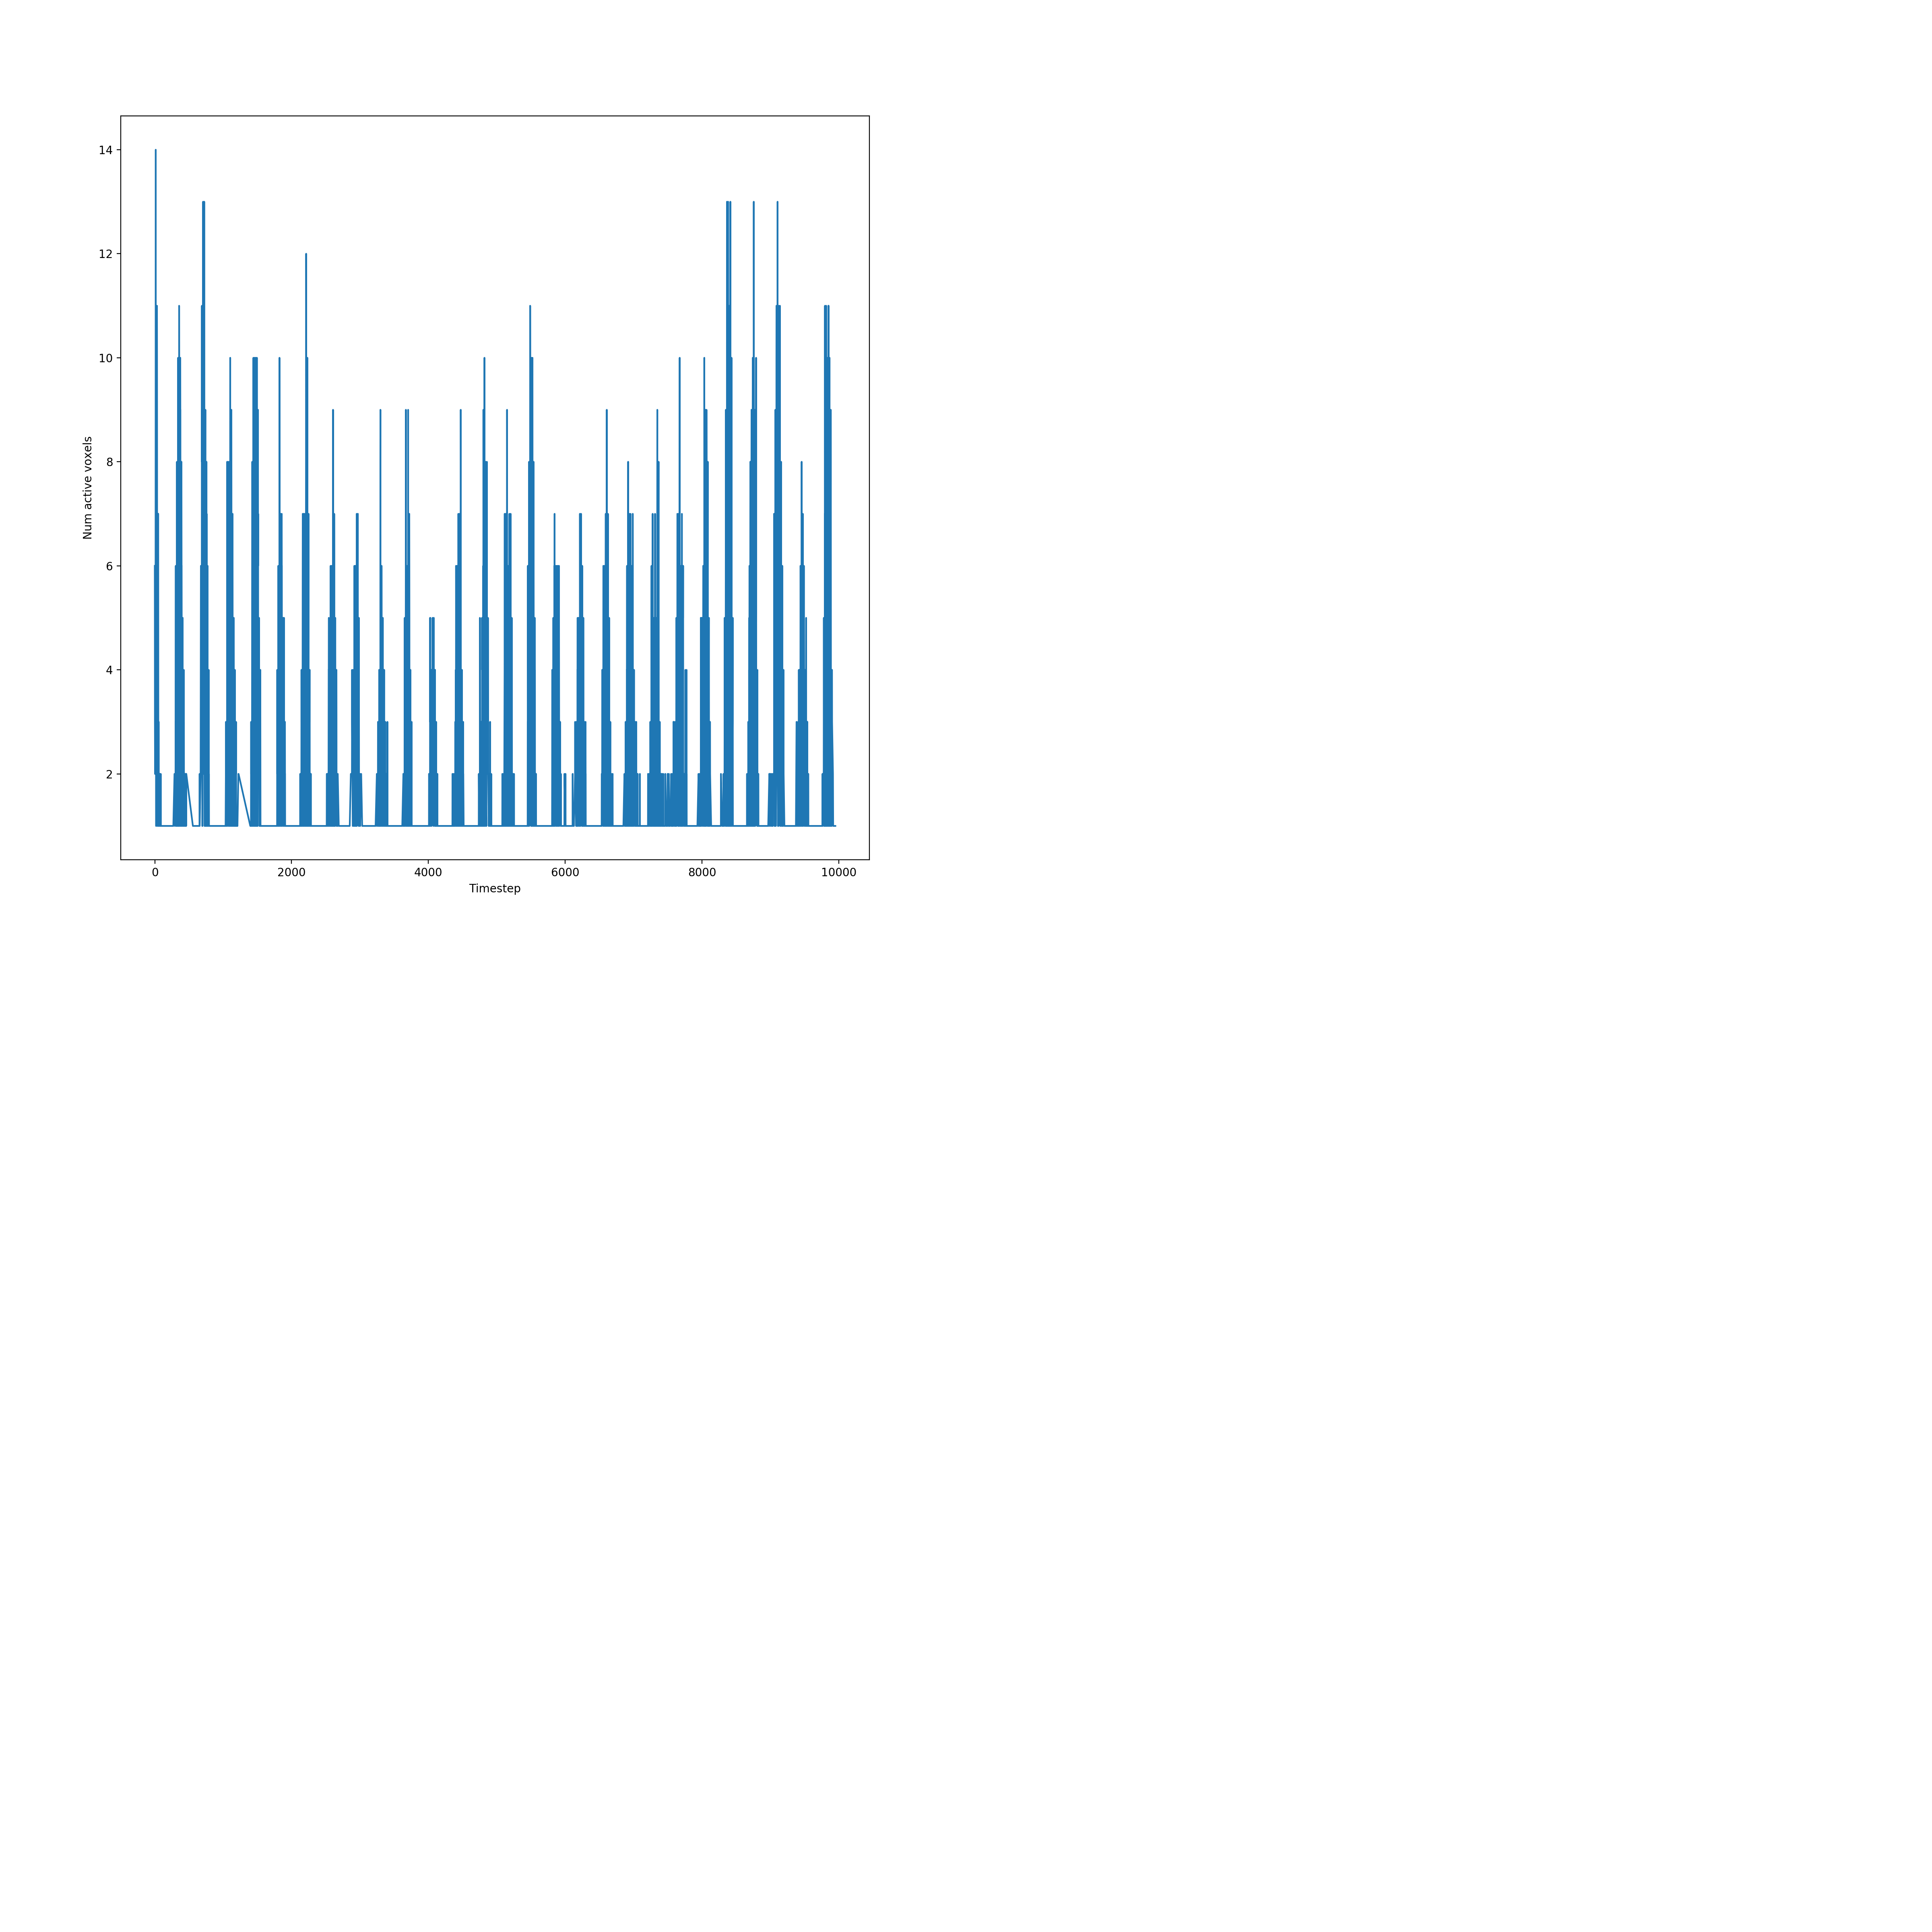

In [70]:
fig, ax = plt.subplots(figsize=(12, 12))

keys = sorted(list(time_evolving_voxels.keys()))
keys_sub_100 = [k for k in keys if k < 100]
values = [len(time_evolving_voxels[k]) for k in keys]
values_sub_100 = [len(time_evolving_voxels[k]) for k in keys_sub_100]

ax.set_xlabel('Timestep')
ax.set_ylabel('Num active voxels')

ax.plot(keys, values)
# ax.plot(keys_sub_100, values_sub_100)


NameError: name 'k' is not defined

In [117]:
import numpy as np
cascade_indices = {}
clusters = skl_cluster.KMeans(n_clusters=28, init='k-means++', n_init=1000, max_iter=1000, tol=0.0001,
                              precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True,
                              n_jobs='deprecated', algorithm='auto').fit(np.array(keys).reshape(-1,1))
for key in keys:
    index = clusters.predict(np.array(key).reshape(-1, 1))
    if cascade_indices.get(index[0]):
        cascade_indices[index[0]].append((key, time_evolving_voxels[key]))
    else:
        cascade_indices[index[0]] = [(key, time_evolving_voxels[key])]

for i,key in enumerate(cascade_indices.keys()):
    print("Cascade {}: {}".format(i, cascade_indices[key]))


Cascade 0: [(0.0, [(0.7355210708873017, -8.0124044960004, -0.5313162146131205), (2.2355210708873017, -0.5124044960004, 0.9686837853868795), (0.7355210708873017, 0.9875955039996, 0.9686837853868795), (3.2355210708873017, 6.9875955039996, 4.9686837853868795), (-4.264478929112698, 1.9875955039996, 0.4686837853868795), (-3.7644789291126983, 0.9875955039996, 0.9686837853868795)]), (1.0, [(0.7355210708873017, -8.0124044960004, -0.5313162146131205), (2.2355210708873017, -0.5124044960004, 0.9686837853868795), (0.7355210708873017, 0.9875955039996, 0.9686837853868795), (-4.264478929112698, 1.9875955039996, 0.4686837853868795), (-3.7644789291126983, 0.9875955039996, 0.9686837853868795)]), (2.0, [(0.7355210708873017, 0.9875955039996, 0.9686837853868795), (-4.264478929112698, 1.9875955039996, 0.4686837853868795), (-3.7644789291126983, 0.9875955039996, 0.9686837853868795)]), (4.0, [(-2.2644789291126983, 0.48759550399960006, 0.4686837853868795), (-6.264478929112698, -7.0124044960004, -0.5313162146131